# Scalability of distributed machine learning

Lets consider bulk synchronous parallel processing model. Time of one iteration consists of computation and communication times that depend on the number of operations C, data D and number of nodes n.
  - T = tcm + tcp
  - tcp = C * f2(n)
  - tcm = D * f1(n)

In [384]:
import math
def tcp(n, flops, p):
    return flops / (n * p)
def tcm(n, weights, b, c):
    return 2 * (weights / b + c) * math.log (n, 2)
def t(n, weights, flops, b, c, p):
    return tcp(n, flops, p) + tcm(n, weights, b, c)


## Scalability of distributed deep learning
### Weights and Flops estimation

The following formulas give estimations of number of weights and operations for training fully-connected and convolutional neural networks. Training consists of the forward propagation, backpropagation of error and gradient computation. Lest consider fully-connected networks:
  - Weights: intputs times outputs for each layer plus bias: w = Sum(mn+n)
  - Training 
    - Forward: vector-matrix multiplication for each layer, bias addition and activation function, ~2mn=2w
    - Backward: vector-matrix and elementwise vector multiplications, ~2nm = 2w
    - Gradient computation: column-vector row-vector products, ~nm = w
    - Gradient update and total: 5w + 1w = 6w
    - Counting "multiply-add" operations: 3w

In [385]:
def weightsAndFlops(layers):
    w = 0
    for i in range(1, len(layers)):
        w = w + layers[i - 1] * layers[i] + layers[i]
    return (w, 6 * w)
assert(weightsAndFlops([784, 10])[0] == 7850)

Convolutional neural networks:
  - Weights: (feature maps size plus bias) times depth and number of maps
  - Training
     - Forward: dot product of input and weights, summation of the result and bias addition, for each feature map and output neuron
     - Backward: similar
     - Gradient computation: similar
     - Total in "multiply-add" operations: 3w
     
Bias adds a lot more weights to convolutional networks, so in recent papers it is not used given that data is normalized.

In [412]:
import numpy as np
def computeConvOutput(data, layer):
    n = layer['count']
    k = layer['size']
    b = layer['border']
    s = layer['stride']
    c = (data[0] - k + b) // s + 1   
    return [c, c, n]
def computePoolOutput(data, layer):
    n = data[2]
    k = layer['size']
    b = layer['border']
    s = layer['stride']
    c = (data[0] - k + b) // s + 1   
    return [c, c, n]
def cnnWeightsAndFlops(inputLayer, layers, useBias):
    w = 0.0
    f = 0.0
    inputData = inputLayer
    for i in range(0, len(layers)):
        layer = layers[i]
        if (layer['type'] == 'conv'):
            n = layer['count']
            k = layer['size']
            d = layer['depth']
            inputData = computeConvOutput(inputData, layer)
            c = inputData[0]
            bw = 0
            if (useBias): 
                bw = c * c
            w = w + n * (k * k * d + bw)
            f = f + n * (k * k * d * c * c)
        if (layer['type'] == 'pool'):
            n = inputData[2]
            inputData = computePoolOutput(inputData, layer)
        if (layer['type'] == 'full'):
            k = layer['size']
            inputFlat = np.product(inputData)
            bw = 0
            if (useBias):
                bw = k
            w = w + k * inputFlat + bw
            f = f + k * inputFlat + k
            inputData = [k]
    return (w, 3 * f)
def cnnWeightsAndFlops2(inputLayer, layers):
    w = 0.0
    f = 0.0
    inputData = inputLayer
    for i in range(0, len(layers)):
        layer = layers[i]
        if (layer['type'] == 'conv'):
            n = layer['count']
            k = layer['size']
            d = layer['depth']
            inputData = computeConvOutput(inputData, layer)
            c = inputData[0]
            dw = n * (k * k * d) # no bias + c * c)
            w = w + dw
            df = n * (k * k * d * c * c)
            f = f + df
            print("layer: ", i, " w: ", dw, " f: ", df)
        if (layer['type'] == 'pool'):
            n = inputData[2]
            inputData = computePoolOutput(inputData, layer)
        if (layer['type'] == 'full'):
            k = layer['size']
            inputFlat = np.product(inputData)
            dw = k * inputFlat
            w = w + dw
            df = dw
            f = f + df
            inputData = [k]
            print("layer: ", i, "w: ", dw, " f: ", df)
    return (w, 3 * f)
weights, flops = cnnWeightsAndFlops([227, 227, 3], [
                           {'type' : 'conv', 'count' : 96, 'size' : 11, 'depth' : 3, 'stride': 4, 'border' : 0},
                           {'type' : 'pool', 'size' : 3, 'stride': 2, 'border' : 0},
                           {'type' : 'conv', 'count' : 256, 'size' : 5, 'depth' : 48, 'stride': 1, 'border' : 4},
                           {'type' : 'pool', 'size' : 3, 'stride': 2, 'border' : 0},
                           {'type' : 'conv', 'count' : 384, 'size' : 3, 'depth' : 256, 'stride': 1, 'border' : 2},
                           {'type' : 'conv', 'count' : 384, 'size' : 3, 'depth' : 384, 'stride': 1, 'border' : 2}, # depth is 192 in paper
                           {'type' : 'conv', 'count' : 256, 'size' : 3, 'depth' : 192, 'stride': 1, 'border' : 2},
                           {'type' : 'pool', 'size' : 3, 'stride': 2, 'border' : 0}, 
                           {'type' : 'full', 'size' : 4096},
                           {'type' : 'full', 'size' : 4096},
                           {'type' : 'full', 'size' : 1000}
                          ], False)
print(weights, flops)


61618208.0 2509668888.0


Unit test

In [408]:
# LeCun et al. 1982 (1068 + 2592 + 5790 + 310 == 9760 weights)
assert cnnWeightsAndFlops([16, 16, 1], [{'type' : 'conv', 'count' : 12, 'size' : 5, 'depth' : 1, 'stride': 2, 'border' : 3}], True)[0] == 1068
assert cnnWeightsAndFlops([16, 16, 1], [{'type' : 'conv', 'count' : 12, 'size' : 5, 'depth' : 1, 'stride': 2, 'border' : 3},
                         {'type' : 'conv', 'count' : 12, 'size' : 5, 'depth' : 8, 'stride': 2, 'border' : 3},
                         {'type' : 'full', 'size' : 30},
                         {'type' : 'full', 'size' : 10}], True)[0] == 9760
# Krizhevsky et al. 2012, AlexNet, see also https://github.com/BVLC/caffe/blob/master/models/bvlc_alexnet/deploy.prototxt
assert(computeConvOutput([227, 227, 3], {'type' : 'conv', 'count' : 96, 'size' : 11, 'depth' : 3, 'stride': 4, 'border' : 0}) == [55, 55, 96])
assert(computePoolOutput([55, 55, 96], {'type' : 'pool', 'size' : 3, 'stride': 2, 'border' : 0}) == [27, 27, 96])
assert(computeConvOutput([27, 27, 256], {'type' : 'conv', 'count' : 256, 'size' : 5, 'depth' : 48, 'stride': 1, 'border' : 4}) == [27, 27, 256])
assert(computePoolOutput([27, 27, 256], {'type' : 'pool', 'size' : 3, 'stride': 2, 'border' : 0}) == [13, 13, 256])
assert(computeConvOutput([13, 13, 256], {'type' : 'conv', 'count' : 384, 'size' : 3, 'depth' : 256, 'stride': 1, 'border' : 2}) == [13, 13, 384])
assert(computeConvOutput([13, 13, 384], {'type' : 'conv', 'count' : 384, 'size' : 3, 'depth' : 192, 'stride': 1, 'border' : 2}) == [13, 13, 384])
assert(computeConvOutput([13, 13, 256], {'type' : 'conv', 'count' : 256, 'size' : 3, 'depth' : 192, 'stride': 1, 'border' : 2}) == [13, 13, 256])
assert(computePoolOutput([13, 13, 256], {'type' : 'pool', 'size' : 3, 'stride': 2, 'border' : 0}) == [6, 6, 256])

# print(computeConvOutput([227, 227, 3], {'type' : 'conv', 'count' : 64, 'size' : 7, 'depth' : 1, 'stride': 2, 'border' : 2}))
# print("w, f", cnnWeightsAndFlops2([227, 227, 3], [{'type' : 'conv', 'count' : 64, 'size' : 7, 'depth' : 1, 'stride': 2, 'border' : 2}]))


### Scalability of fully connected networks

### Scalability of convolutional networks

AlexNet

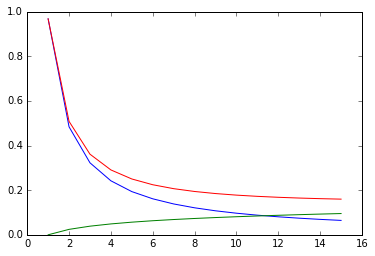

In [409]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
n = np.arange(1, 16)
weights, flops = cnnWeightsAndFlops([227, 227, 3], [{'type' : 'conv', 'count' : 96, 'size' : 11, 'depth' : 3, 'stride': 4, 'border' : 0},
                           {'type' : 'pool', 'size' : 3, 'stride': 2, 'border' : 0},
                           {'type' : 'conv', 'count' : 256, 'size' : 5, 'depth' : 48, 'stride': 1, 'border' : 4},
                           {'type' : 'pool', 'size' : 3, 'stride': 2, 'border' : 0},
                           {'type' : 'conv', 'count' : 384, 'size' : 3, 'depth' : 256, 'stride': 1, 'border' : 2},
                           {'type' : 'conv', 'count' : 384, 'size' : 3, 'depth' : 192, 'stride': 1, 'border' : 2},
                           {'type' : 'conv', 'count' : 256, 'size' : 3, 'depth' : 192, 'stride': 1, 'border' : 2},
                           {'type' : 'pool', 'size' : 3, 'stride': 2, 'border' : 0}, 
                           {'type' : 'full', 'size' : 4096},
                           {'type' : 'full', 'size' : 4096},
                           {'type' : 'full', 'size' : 1000}
                          ], False)
flops = flops * 1024
weights = weights * 32
p = 2.3e12
b = 20 * 8 * 1e9
c = 0.0
vtcp = np.vectorize(tcp)
vtcm = np.vectorize(tcm)
vt = np.vectorize(t)
tcomp = vtcp(n, flops, p)
tcomm = vtcm(n, weights, b, c)
titer = vt(n, weights, flops, b, c, p)
plt.plot(n,tcomp)
plt.plot(n,tcomm)
plt.plot(n, titer)
#plt.ylabel('some numbers')

In [402]:
t(1, weights, 7e12, b, c, p) / t(32, weights, 7e12, b, c, p) 

14.022893753905997

In [403]:
flops / 1024

2173248024.0